In [6]:
import os
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from my_utils import print_red, print_cyan, print_green, fast_rolling_average
os.system("")
"""
Inputs:
df of net load

Outputs:
CFD plot and VRE event df for fingerprint matching
"""

def fast_cfd(df_netload, amp_length = 0.1):
    df_freq = pd.DataFrame()
    output = {}
    dfrows=df_netload.index
    print("index = ",dfrows)
    net_loads_array = np.array(df_netload["net load"].values)
    print("vals = ",net_loads_array)
    print("len of vals = ",len(net_loads_array))
    amps = np.arange(minval, maxval, amp_length).tolist()
    print("length of amps:",len(amps))
    start_time = timer()
    for amp in amps:
        # initiate variables before row loop
        d = {'net load': net_load,'count1':0,'count2':0}
        df_netload = pd.DataFrame(data=d)
        previous_row = dfrows[0]
        previous_net_load_val = net_loads_array[0]
        amp_positive = amp>=0
        amp_negative = not amp_positive
        for i_r, row in enumerate(dfrows):
            #net_load_val = df_netload.at[row,'net load']
            net_load_val = net_loads_array[i_r]
            netload_greater_than_amp = net_load_val>=amp
            netload_smaller_than_amp = not netload_greater_than_amp
            previous_netload_greater_than_amp = previous_net_load_val>=amp
            previous_netload_smaller_than_amp = not previous_netload_greater_than_amp
            # both count1 and count2 are related to the duration of events
            if amp_positive and netload_greater_than_amp:
    #            df_netload.set_value(row, 'count1', df_netload.at[previous_row,'count1']+1)
                try: df_netload.at[row, 'count1']= df_netload.at[previous_row,'count1']+1
                except KeyError as e:
                    print(row,amp)
                    print(df_netload.at[row, 'count1'])
                    print(df_netload.at[previous_row, 'count1'])
                    raise e
            elif amp_negative and netload_smaller_than_amp:
    #            df_netload.set_value(row, 'count1', df_netload.at[previous_row,'count1']+1)
                try: df_netload.at[row, 'count1']= df_netload.at[previous_row,'count1']+1
                except KeyError as e:
                    print(row,amp)
                    print(df_netload.at[row, 'count1'])
                    print(df_netload.at[previous_row, 'count1'])
                    raise e
    # spara sedan varje periods längd vid sluttillfället
            if amp_positive and previous_netload_greater_than_amp and netload_smaller_than_amp:
    #            df_netload.set_value(previous_row, 'count2', df_netload.at[previous_row,'count1'])
                df_netload.at[previous_row, 'count2']= df_netload.at[previous_row,'count1']
            elif amp_negative and previous_netload_smaller_than_amp and netload_greater_than_amp:
    #            df_netload.set_value(previous_row, 'count2', df_netload.at[previous_row,'count1'])
                df_netload.at[previous_row, 'count2']= df_netload.at[previous_row,'count1']
            previous_row=row
            previous_net_load_val = net_load_val
        # this sets the recurrence by counting the durations for each amplitude
        s=df_netload.count2.value_counts()
        df_freq=pd.DataFrame(data=s)
    #    s_form=list(s)
        output[amp]=df_freq
    #df_out=pd.DataFrame(data=output, index=[amp])
    #df_out = pd.DataFrame()
    print(f"time to build df_freq for all amps = {round(timer() - start_time,1)}")
    start_time = timer()
    df_out_tot = pd.DataFrame()
    #output2 = {}
    for amp in amps:
        df_out = output[amp]
        df_out = df_out.iloc[1:]
        df_out.index.name = 'Duration'
        df_out = pd.concat([df_out], keys=[amp], names=['Amplitude'])
        df_out.rename(columns={'count2':'Occurences'}, inplace=True)
        df_out_tot=df_out_tot.append(df_out)
    #    output2[amp] = df_out
    #df_out[0]
    print(f"time to build df_out_tot = {round(timer() - start_time,1)}")
    return df_out_tot


year = "1980-2019"#1981
#data = pickle.load(open("PickleJar\\netload_components_1980-2019.pickle","rb"))
data = pickle.load(open(f"PickleJar\\netload_components_{year}.pickle","rb"))
print(data.keys())
VRE_profiles = data["VRE_profiles"]
load = data["load"]
cap = data["cap"]
#VRE_profiles
#load
#cap
if type(load)==dict:
    load_list = []
    for year, load in load.items():
        load_list += list(load)
    load = np.array(load_list)
if load.ndim > 1:
    load = load.sum(axis=1)

net_load = -(VRE_profiles*cap).sum(axis=1) + load
print(VRE_profiles.shape, net_load.shape, cap.shape)

dict_keys(['VRE_profiles', 'cap', 'load', 'non_traditional_load'])
(350640, 120) (350640,) (53,)


In [7]:
#net_load=((-1)*df_disp['bat_ch'])
#net_load=(df_disp['WG_peak'])
#d = {'net load': net_load,'count1':0,'count2':0}
#df_netload = fast_rolling_average(pd.DataFrame(data=d),1)
array_netload = fast_rolling_average(net_load,12)
df_netload = pd.DataFrame(data={'net load': array_netload,'count1':0,'count2':0})
#maxind, maxval = max(net_load, key=lambda item: item[1])
maxval=int(math.ceil(df_netload["net load"].max()))
minval=int(math.floor(df_netload["net load"].min()))
print(df_netload, minval,maxval)

             net load  count1  count2
1980 h0001  81.826075       0       0
     h0002  81.826075       0       0
     h0003  81.826075       0       0
     h0004  81.826075       0       0
     h0005  83.346753       0       0
...               ...     ...     ...
2019 h8756  41.777686       0       0
     h8757  42.810959       0       0
     h8758  45.166556       0       0
     h8759  49.262306       0       0
     h8760  56.253283       0       0

[350640 rows x 3 columns] -118 186


In [8]:
#df_netload is a pandas dataframe with multiindex and 3 columns
#i want to collapse the multiindex and replace it with just a number range
#df_netload = df_netload.reset_index()[["net load", "count1", "count2"]]
#df_netload.at[2632,"count1"]

In [9]:
amp_length = 1
pickle_read_name = ""
pickle_dump_name = rf"PickleJar\1980-2019_CFD_netload_df_amp{amp_length}.pickle"
if pickle_read_name:
    df_out_tot = pickle.load(open(pickle_read_name,"rb"))
else:
    start_time = timer()
    df_out_tot = fast_cfd(df_netload, amp_length=amp_length) # 248s at 1 year then more changes and now 156-157s at 1 year
    end_time = timer()
    print(f"elapsed time = {round(end_time - start_time,1)}")
print(df_out_tot)

index =  MultiIndex([(1980, 'h0001'),
            (1980, 'h0002'),
            (1980, 'h0003'),
            (1980, 'h0004'),
            (1980, 'h0005'),
            (1980, 'h0006'),
            (1980, 'h0007'),
            (1980, 'h0008'),
            (1980, 'h0009'),
            (1980, 'h0010'),
            ...
            (2019, 'h8751'),
            (2019, 'h8752'),
            (2019, 'h8753'),
            (2019, 'h8754'),
            (2019, 'h8755'),
            (2019, 'h8756'),
            (2019, 'h8757'),
            (2019, 'h8758'),
            (2019, 'h8759'),
            (2019, 'h8760')],
           length=350640)
vals =  [81.82607498 81.82607498 81.82607498 ... 45.16655634 49.26230624
 56.25328274]
len of vals =  350640
length of amps: 152
time to build df_freq for all amps = 472.9
time to build df_out_tot = 0.3
elapsed time = 473.2
                    Occurences
Amplitude Duration            
-116      2                  1
-114      3                  2
-112      4         

In [10]:
if pickle_dump_name: pickle.dump(df_out_tot, open(pickle_dump_name,'wb'))


In [126]:
df_reset = df_out_tot.reset_index()
df_reset.columns = ['Amplitude', 'Duration', 'Occurrence']
df_pivot=df_reset.pivot('Amplitude', 'Duration')
#print(df_reset)
filtered_df = df_reset[df_reset['Amplitude'].round(1) == 25.5]
print(filtered_df)
#print(df_pivot.max(axis=1, skipna=True))
df_reset["Energy"] = df_reset["Amplitude"]*df_reset["Duration"]*np.sign(df_reset["Amplitude"])
from scipy.signal import argrelextrema, find_peaks, argrelmax
#find each unique value and its index from dataframe array
unique_amps, unique_amps_index = np.unique(df_reset["Amplitude"],return_index=True)
#print(df_pivot[df_pivot.columns[df_pivot.columns.get_level_values(1) > 375]].to_string())
#print(df_pivot[df_pivot.columns[df_pivot.columns.get_level_values(1) > 1300]].fillna(0)[df_pivot != 0])
#print(df_pivot[df_pivot["Duration"] >1300].fillna(0).sum())
Y=df_pivot.columns.levels[1].values
X=df_pivot.index.values
Z=df_pivot.values
print_cyan("Y =", Y, Y.shape)
#print_green("X =", X, X.shape)
print_red("Z =", Z)
#df1['A'] = df1['A'].apply(lambda x: [y if y <= 9 else 11 for y in x])
Znetload=np.where(Z > 50, 50, Z)
Ynetload,Xnetload = np.meshgrid(Y, X)
import scipy.io
scipy.io.savemat(f"output\\heatmap_values_{year}", {"amplitude":Ynetload, "duration":Xnetload, "recurrance":Znetload})
#print({"amplitude":Xnetload, "duration":Ynetload, "recurrance":Znetload})
Z_testing = np.nan_to_num(Znetload)
print(Z_testing.sum(axis=0), Z_testing.sum(axis=0).shape)

Empty DataFrame
Columns: [Amplitude, Duration, Occurrence]
Index: []
Y = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  51  53  54  55  56  57  58
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  78  84  87  89
  90  91  92  93  94  95  96  98 102 103 104 105 106 107 108 109 113 114
 115 116 117 118 119 120 130 131 132 133 134 138 139 140 141 142 143 144
 152 153 154 162 163 164 165 166 167 188 189 201 202 204 205 212 213 214
 215 226 228 229 230 235 236 237 238 239 260 261 262 312 331 332 333 334
 347 348 356 357 358 359 380 381 383 405 406 407 408 500 549 574 597 619] (162,)
Z = [[ 1. nan nan ... nan nan nan]
 [ 1. nan nan ... nan nan nan]
 [ 1. nan nan ... nan nan nan]
 ...
 [nan  1. nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]]
[2.451e+03 3.769e+03 4.164e+03 4.252e+03 3.770e+03 2.628e+03 1.729

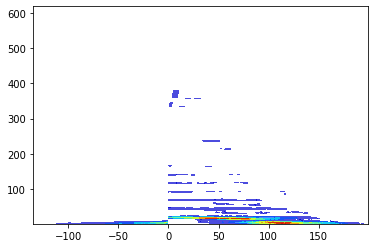

In [135]:
plt.contourf(Xnetload, Ynetload, Znetload, alpha=0.7, cmap=plt.cm.jet,antialiased=False)
plt.savefig(f"figures\\cfd_{year}_fastfunc.png",dpi=800)

#plt.show()

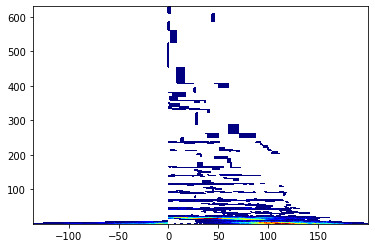

In [151]:
import matplotlib as mpl
#mpl.rcParams["patch.force_edgecolor"]=True
plt.pcolormesh(Xnetload,Ynetload,Znetload, alpha=1,linewidth=0, shading='nearest', cmap=plt.cm.jet)#, alpha=0.7)
plt.savefig(f"figures\\cfd_{year}_fastfunc2.png",dpi=800)